In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
#muller-brown potential

def V(x,y):
    prefactor = 0.15
    A=(-200,-100,-170,15)
    a=(-1,-1,-6.5,0.7)
    b=(0,0,11,0.6)
    c=(-10,-10,-6.5,0.7)
    x0=(1,0,-0.5,-1)
    y0=(0,0.5,1.5,1)
    offset = -146.7

    v = -prefactor*offset
    for i in range(4):
        v += prefactor * A[i]*np.exp( a[i]*(x-x0[i])**2 + b[i]*(x-x0[i])*(y-y0[i]) + c[i]*(y-y0[i])**2 )
    return v

MULLER_BROWN_FORMULA='0.15*(146.7-200*exp(-1*(x-1)^2+0*(x-1)*(y-0)-10*(y-0)^2)-100*exp(-1*(x-0)^2+0*(x-0)*(y-0.5)-10*(y-0.5)^2)-170*exp(-6.5*(x+0.5)^2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)^2)+15*exp(0.7*(x+1)^2+0.6*(x+1)*(y-1)+0.7*(y-1)^2))'

nx, ny = (100, 100)
xlims=(-1.8, 1.2)
ylims=(-0.4, 2.1)
x = np.linspace(xlims[0],xlims[1], nx)
y = np.linspace(ylims[0],ylims[1], ny)
xv, yv = np.meshgrid(x, y)

pot = V(xv,yv)
max_pot = 26
pot[pot>max_pot] = max_pot

In [3]:
folder = 'raw_data/Muller_Brown/'

#load 
colvar=plumed.read_as_pandas(folder+"COLVAR_ABMD_kappa05")
print(len(colvar))
colvar2 = plumed.read_as_pandas(folder+"COLVAR_ABMD_kappa125")
print(len(colvar2))

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/frohlkin@farma.unige.ch/anaconda3/envs/MLpathcv/lib/libplumedKernel.so" +++


2145911


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/frohlkin@farma.unige.ch/anaconda3/envs/MLpathcv/lib/libplumedKernel.so" +++


1652341


In [4]:
dynamics=np.array(colvar.iloc[:,:3],dtype=float)[::-1]

transition=[]
for t in dynamics:
    
    transition.append(t[1:])
        
    if t[2] < 0.0:
        break
transition=torch.Tensor(transition)

dynamics2=np.array(colvar2.iloc[:,:3],dtype=float)[::-1]

transition2=[]
for t in dynamics2:
    
    transition2.append(t[1:])
        
    if t[2] < 0.0:
        break      
transition2=torch.Tensor(transition2)

training_datapoints=np.vstack((transition,transition2))


from skmatter.feature_selection import FPS

selector = FPS(n_to_select=500,initialize=0)

selector.fit(training_datapoints.T)
model_datapoints = selector.transform(training_datapoints.T).T

print(model_datapoints.shape)

(500, 2)


/tmp/ipykernel_721772/2000991473.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  transition=torch.Tensor(transition)


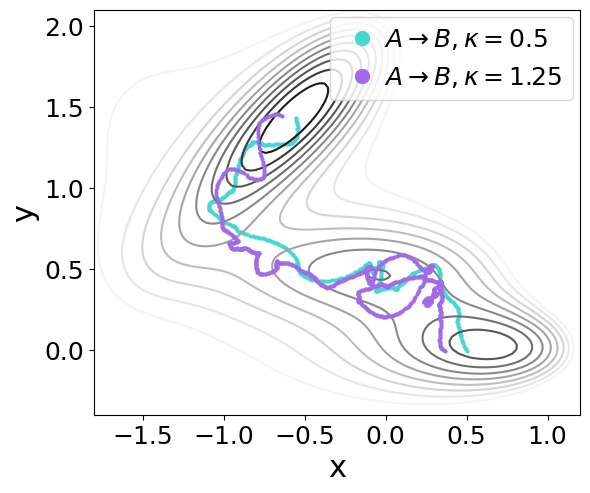

In [31]:
# plot pot isolines + samples
fig, ax = plt.subplots(1, figsize=(6,6), dpi=100)
pp = ax.contour(xv,yv,pot,10,cmap='Greys_r')
pot2=V(transition[:,0], transition[:,1])
pot3=V(transition2[:,0], transition2[:,1])
pot4=V(training_datapoints[:,0], training_datapoints[:,1])
plt.plot(transition[:,0], transition[:,1],'o',color='#48D6D2',markersize=2,alpha=1,label=r'$A\rightarrow B, \kappa=0.5$',zorder=1)
plt.plot(transition2[:,0], transition2[:,1],'o',color='#A16AE8',markersize=2,alpha=1,label=r'$A\rightarrow B, \kappa=1.25$',zorder=2)


plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('x',fontsize=22)
plt.ylabel('y',fontsize=22)
ax.set_aspect('equal')
#plt.legend(loc='upper right',fontsize=18,markerscale=5)
#legend = plt.legend(loc='upper right', fontsize=18, markerscale=5, borderaxespad=0.1)
#legend.set_title(None)  # Remove the default legend title

legend = plt.legend(loc='upper right', fontsize=18, markerscale=5, handlelength=1.75, handletextpad=0.01, borderaxespad=0.3)
legend.set_title(None)  # Remove the default legend title


plt.tight_layout()
plt.show()

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/frohlkin@farma.unige.ch/anaconda3/envs/MLpathcv/lib/libplumedKernel.so" +++


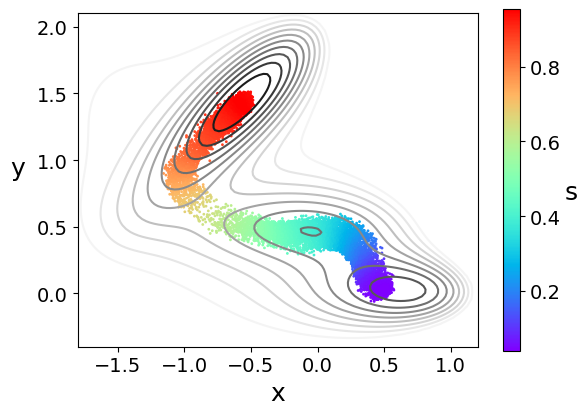

In [33]:
#load 
colvar = plumed.read_as_pandas(folder+"COLVAR_DeepLNE")

# plot pot isolines + samples
fig, ax = plt.subplots(1, figsize=(6,6), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')
#colvar.plot.scatter('p.x','p.y',c='model.node-0',cmap='rainbow_r',s=1,ax=ax)
s =plt.scatter(colvar['p.x'],colvar['p.y'],c=colvar['model.node-0'],cmap='rainbow',s=1)
cbar = plt.colorbar(s,ax=ax, shrink=0.6)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [34]:
def compute_committor(path_to_file,n_sim):

    stateA_counter=0
    stateB_counter=0
    for c in range(n_sim):

        #load 
        colvar = plumed.read_as_pandas(path_to_file+"%s" %str(c))
        last_position_x=colvar.iloc[-1,1]
        if last_position_x < 0:
            stateA_counter+=1
        else:
            stateB_counter+=1
    return stateA_counter/n_sim


start = 0.56
end = 0.75
resolution = 5

bin_edges = np.linspace(start, end, resolution + 1)

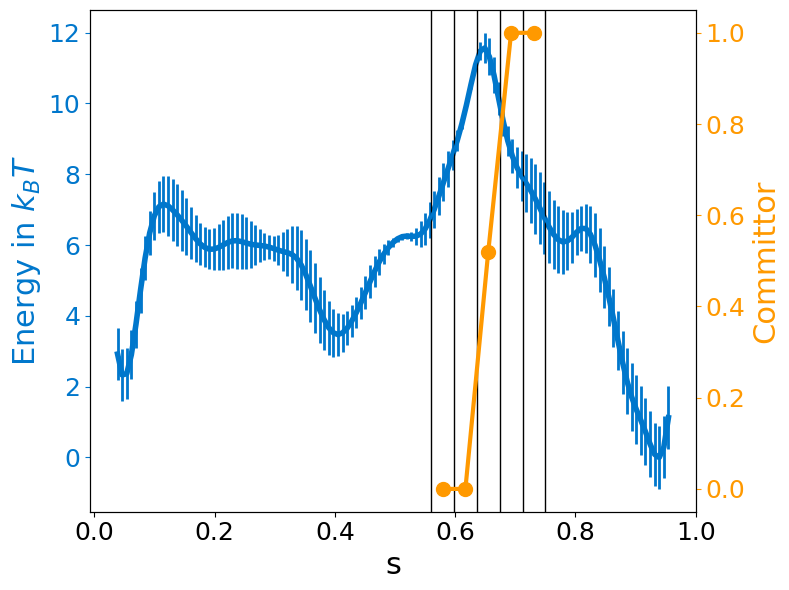

In [35]:
data=np.load(folder+"MB_FES.npy" )
data.shape

fig, ax = plt.subplots(1, figsize=(8,6), dpi=100)
plt.errorbar(data[:,0], data[:,1]*2.479, yerr=data[:,2]*2.479, color='#0077cc',linewidth=2)
plt.plot(data[:,0], data[:,1]*2.479, color='#0077cc',linewidth=4)
plt.ylabel(r'Energy in $k_BT$', color='#0077cc',fontsize=22)
plt.xlabel('s',fontsize=22)

plt.tick_params(axis='y', colors='#0077cc')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


for bin_edge in bin_edges:
    plt.axvline(x=bin_edge, color='black', linestyle='-', linewidth=1)

bin_edges=np.array(bin_edges)

committors=np.load(folder+'MB_committors.npy')

ax2 = plt.gca().twinx()
ax2.plot(0.5*(bin_edges[:resolution]+bin_edges[1:resolution+1]),committors,'o-',color='#ff9900',markersize=10,linewidth=3)
ax2.set_ylabel('Committor', color='#ff9900',fontsize=22)
ax2.tick_params(axis='y', colors='#ff9900',labelsize=18)
plt.tight_layout()
plt.show()

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/frohlkin@farma.unige.ch/anaconda3/envs/MLpathcv/lib/libplumedKernel.so" +++


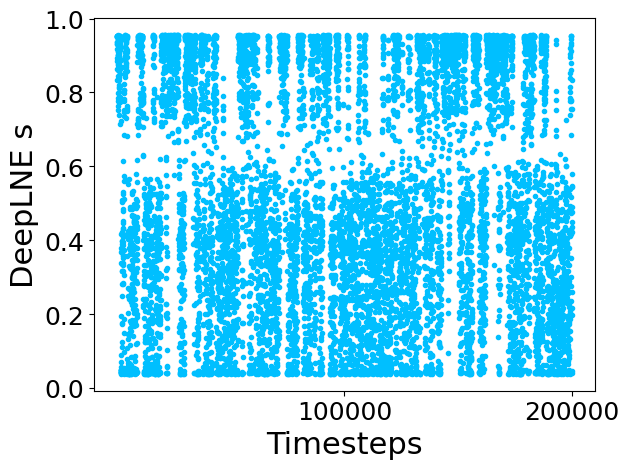

In [36]:
colvar=plumed.read_as_pandas(folder+"COLVAR_DeepLNE") 
t=np.linspace(0,2000000, num=10001)

fig=plt.figure()
plt.plot(t,colvar['model.node-0'],'.',color='#00BFFF',alpha=1)
plt.xlabel(r'Timesteps',fontsize=22)
plt.ylabel(r'DeepLNE s',fontsize=22)
plt.xticks([t[5000], t[10000]], labels=['100000', '200000'], fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

In [5]:
class DeepLNE_CV(nn.Module):

    def __init__(self,
                ANN_layers: list,
                AutoEncoder_layers: list,
                f: int,
                d: int,
                n: int,
                ref: torch.Tensor,
                ref_z: torch.Tensor,
                act: str,
                z_lambda: float):
        

        super(DeepLNE_CV,self).__init__()
        
        # =======   LOSS  =======
        self.loss_mse = torch.nn.MSELoss()
        

        # ======= BLOCKS =======
        
        self.n_features=f
        self.n_neighbors=n
        self.d_metric=d
        self.training_datapoints=ref
        self.training_datapoints_z=ref_z
        self.z_lambda=z_lambda
        
        print('Numer of input features:',self.n_features)
        print('Numer of neighbors:',self.n_neighbors)
        print('Dimension for nn search:',self.d_metric)
         
        if act == 'ReLU':
            self.activationf=torch.nn.ReLU()
        if act == 'Tanh':
            self.activationf=torch.nn.Tanh()
        if act == 'Sigmoid':
            self.activationf=torch.nn.Sigmoid()
        if act == 'ELU':
            self.activationf=torch.nn.ELU()
        
        self.ANNlayers = []
        
        self.ANNlayers.append(torch.nn.Linear(self.n_features, ANN_layers[0]))
        self.ANNlayers.append(self.activationf)
        
        for i in range(len(ANN_layers) - 1):
            self.ANNlayers.append(torch.nn.Linear(ANN_layers[i], ANN_layers[i + 1]))
            self.ANNlayers.append(self.activationf)

        self.ANNlayers.append(torch.nn.Linear(ANN_layers[-1], self.d_metric))
        
        self.metric = torch.nn.Sequential(*self.ANNlayers)
        print('ANN architecture: ',self.metric)
            

        # initialize encoder
        self.AutoEncoderLayers = []
        
        self.AutoEncoderLayers.append(torch.nn.Linear(int(self.n_neighbors*self.d_metric), AutoEncoder_layers[0]))
        self.AutoEncoderLayers.append(self.activationf)
        
        for i in range(len(AutoEncoder_layers) - 1):
            self.AutoEncoderLayers.append(torch.nn.Linear(AutoEncoder_layers[i], AutoEncoder_layers[i + 1]))
            self.AutoEncoderLayers.append(self.activationf)

        self.AutoEncoderLayers.append(torch.nn.Linear(AutoEncoder_layers[-1], 1))
        self.AutoEncoderLayers.append(torch.nn.Sigmoid())

        self.encoder = torch.nn.Sequential(*self.AutoEncoderLayers)
        print('Encoder architecture: ',self.encoder)
        
        # initialize decoder
        self.AutoDecoderLayers = []
        AutoDecoder_layers=AutoEncoder_layers[::-1]
        
        self.AutoDecoderLayers.append(torch.nn.Linear(1, AutoDecoder_layers[0]))
        self.AutoDecoderLayers.append(self.activationf)
        
        for i in range(len(AutoDecoder_layers) - 1):
            self.AutoDecoderLayers.append(torch.nn.Linear(AutoDecoder_layers[i], AutoDecoder_layers[i + 1]))
            self.AutoDecoderLayers.append(self.activationf)

        self.AutoDecoderLayers.append(torch.nn.Linear(AutoDecoder_layers[-1], self.n_features))

        self.decoder = torch.nn.Sequential(*self.AutoDecoderLayers)
        print('Decoder architecture: ',self.decoder)
    
    def softmax_w(self,x: torch.Tensor, t=1e-1) -> torch.Tensor:
        x = x / t
        x = x - torch.max(x, dim=1, keepdim=True)[0]
        return (torch.exp(x)+1e-4) / torch.sum(torch.exp(x), dim=1, keepdim=True)
        

    def soft_top_k(self,x: torch.Tensor,t: torch.Tensor) -> torch.Tensor:
        y = torch.zeros_like(x)
        
        x_w = x * (1 - y)
        x_w_softmax = self.softmax_w(x_w)
        y = y+x_w_softmax
            
        for k in range(self.n_neighbors):
            x_w = x * (1 - y)
            x_w_softmax = self.softmax_w(x_w)
            y = y+x_w_softmax
            
            dm=torch.matmul(t.T,x_w_softmax.T)
            
            if k == 0:
                dn=dm
            else:
                dn=torch.cat((dn,dm))
        return dn.T

    def learn_metric(self,x: torch.Tensor) -> torch.Tensor:
        d=self.metric(x)
        t=self.metric(self.training_datapoints)
        return d,t
    
    def find_nearest_neighbors(self,x: torch.Tensor,t: torch.Tensor) -> torch.Tensor:
        
        dist = torch.cdist(x, t)
        dist=torch.exp(-dist)
        dn = self.soft_top_k(dist,t)
        
        return dn
        
    def encode(self,x: torch.Tensor) -> torch.Tensor:
        x=self.encoder(x)
        return x
    
    def decode(self,x: torch.Tensor) -> torch.Tensor:
        x=self.decoder(x)
        return x
    
    def encode_decode(self, x: torch.Tensor) -> torch.Tensor:
        d,t=self.learn_metric(x)
        dn=self.find_nearest_neighbors(d,t)
        
        s=self.encode(dn)
        x_hat=self.decode(s) 
        
        return x_hat,s,d,dn
    
    def forward(self, x: torch.Tensor) -> torch.Tensor :
        d,t=self.learn_metric(x)
        dn=self.find_nearest_neighbors(d,t)
        s=self.encode(dn).reshape(-1,1)
        z=self.compute_z(x).reshape(-1,1)
        
        out=torch.hstack((s,z))
        
        return out
    
    def compute_z(self,x: torch.Tensor) -> torch.Tensor:
        z_dist=torch.cdist(x,self.training_datapoints_z)
        z_dist=torch.absolute(z_dist)
        z=(-1/self.z_lambda)*torch.log(torch.sum(torch.exp(-self.z_lambda*z_dist),axis=1))

        return z

In [9]:
training_datapoints=torch.Tensor(training_datapoints)
model_datapoints=torch.Tensor(model_datapoints)

ANN_architecture=[8]
AutoEncoder_architecture=[24,16]

n_features=2
d_metric=3
n_neighbors=3
l=50

model = DeepLNE_CV(ANN_layers=ANN_architecture,
                   AutoEncoder_layers=AutoEncoder_architecture,
                   f=n_features,
                   d=d_metric,
                   n=n_neighbors,
                   ref=model_datapoints,
                   ref_z=model_datapoints,
                   act='Tanh',
                   z_lambda=l)

device = torch.device("cpu")
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.load_state_dict(torch.load('model_params.pt'), strict=False)

Numer of input features: 2
Numer of neighbors: 3
Dimension for nn search: 3
ANN architecture:  Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=3, bias=True)
)
Encoder architecture:  Sequential(
  (0): Linear(in_features=9, out_features=24, bias=True)
  (1): Tanh()
  (2): Linear(in_features=24, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)
Decoder architecture:  Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=24, bias=True)
  (3): Tanh()
  (4): Linear(in_features=24, out_features=2, bias=True)
)


<All keys matched successfully>

In [10]:
model_datapoints_z=model.encode_decode(model_datapoints)[0].detach().numpy()

training_datapoints=torch.Tensor(training_datapoints)
model_datapoints=torch.Tensor(model_datapoints)
model_datapoints_z=torch.Tensor(model_datapoints_z)

plumed_model = DeepLNE_CV(ANN_layers=ANN_architecture,
                   AutoEncoder_layers=AutoEncoder_architecture,
                   f=n_features,
                   d=d_metric,
                   n=n_neighbors,
                   ref=model_datapoints,
                   ref_z=model_datapoints_z,
                   act='Tanh',
                   z_lambda=l)

plumed_model.load_state_dict(torch.load('model_params.pt'), strict=False)

Numer of input features: 2
Numer of neighbors: 3
Dimension for nn search: 3
ANN architecture:  Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=3, bias=True)
)
Encoder architecture:  Sequential(
  (0): Linear(in_features=9, out_features=24, bias=True)
  (1): Tanh()
  (2): Linear(in_features=24, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)
Decoder architecture:  Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=24, bias=True)
  (3): Tanh()
  (4): Linear(in_features=24, out_features=2, bias=True)
)


<All keys matched successfully>

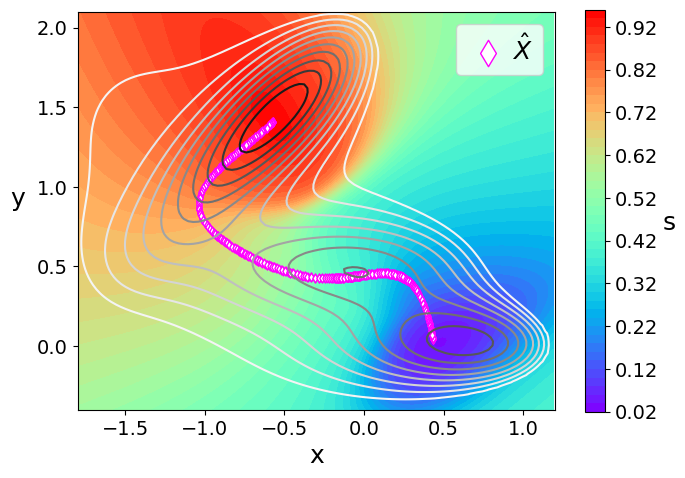

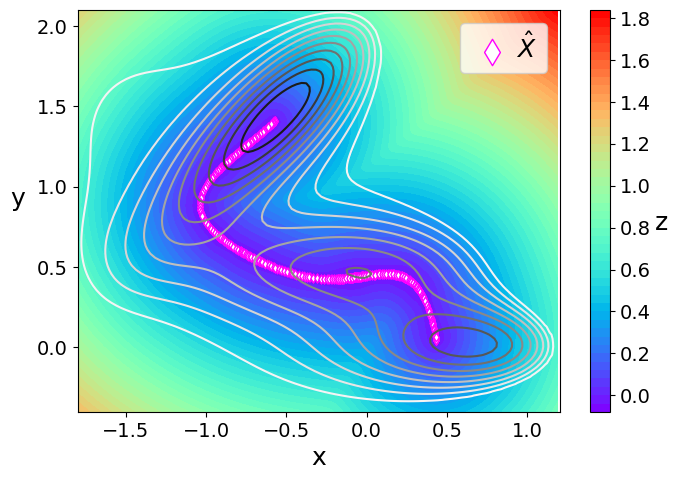

In [11]:
input=model_datapoints
x_hat,s,d,dn=plumed_model.encode_decode(input)
x_hat=x_hat.detach().numpy()

x_range = np.arange(-1.8, 1.2, 0.01)
y_range = np.arange(-0.4, 2.1, 0.01)

# Create a grid of points
x_grid, y_grid = np.meshgrid(x_range, y_range)

grid_points = np.column_stack((x_grid.flatten(), y_grid.flatten()))

sample_grid=torch.Tensor(grid_points)

input=sample_grid
out=plumed_model(input)
s = out[:,0]
z = out[:,1]
s=s.detach().numpy()
z=z.detach().numpy()


grid_x = grid_points[:, 0].reshape(x_grid.shape)  
grid_y = grid_points[:, 1].reshape(x_grid.shape)  
grid_s = s.reshape(x_grid.shape)  
grid_z = z.reshape(x_grid.shape)  


fig, ax = plt.subplots(1, figsize=(7,7))
contour2 = ax.contourf(grid_x,grid_y,grid_s,50,cmap='rainbow')
ax.contour(xv,yv,pot,10,cmap='Greys_r')
plt.scatter(x_hat[:,0], x_hat[:,1],color='white', s=20, marker='d',edgecolors='magenta',label=r'$\hat{X}$')
cbar = plt.colorbar(contour2,ax=ax, shrink=0.6)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
ax.set_aspect('equal')
legend = plt.legend(loc='upper right', fontsize=18, markerscale=3, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, figsize=(7,7))
contour2 = ax.contourf(grid_x,grid_y,grid_z,50,cmap='rainbow')
ax.contour(xv,yv,pot,10,cmap='Greys_r')
plt.scatter(x_hat[:,0], x_hat[:,1],color='white', s=20, marker='d',edgecolors='magenta',label=r'$\hat{X}$')
cbar = plt.colorbar(contour2,ax=ax, shrink=0.6)
cbar.set_label(r'z', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
ax.set_aspect('equal')
legend = plt.legend(loc='upper right', fontsize=18, markerscale=3, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()